<a href="https://colab.research.google.com/github/kinanajoudeh/Cirrhosis-Status-Classification/blob/main/Cirrhosis_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [263]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from imblearn.over_sampling import SMOTE,SMOTENC

# set the default output to pandas
from sklearn import set_config
set_config(transform_output='pandas')

# Modeling
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# To supress warnings
import warnings
warnings.filterwarnings('ignore')

# Data Source and Dictionary

Data will be found on Kaggle [here](https://www.kaggle.com/datasets/fedesoriano/cirrhosis-prediction-dataset?select=cirrhosis.csv)

# Functions

### Univariate EDA Functions

In [123]:
target='Status'
# Basic imports for functions
import matplotlib.pyplot as plt
import seaborn as sns

def explore_categorical(df, x, fillna = True, placeholder = 'MISSING',
                        figsize = (6,4), order = None, ftype='Categorical'):
  temp_df = df.copy()
  null_count = temp_df[x].isna().sum()
  null_perc = null_count/len(temp_df)* 100
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  fig, ax = plt.subplots(figsize=figsize)
  sns.countplot(data=temp_df, x=x, ax=ax, hue=x, order=order)
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  ax.set_title(f"Column: {x}", fontweight='bold')
  fig.tight_layout()
  plt.show()

  # Feature type
  print(f"- Feature Type: {ftype}")
  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = temp_df[x].nunique()
  print(f"- Unique Values: {nunique}")
  car = "Low"
  if nunique >= 10:
    car = "High"
  print(f"- Cardinality: {car}")

  val_counts = temp_df[x].value_counts(dropna=False)
  most_common_val = val_counts.index[0]
  freq = val_counts.values[0]
  perc_most_common = freq / len(temp_df) * 100

  # Print the common value
  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")
  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, ax


def explore_numeric(df, x, figsize=(6,5)):
  null_count = df[x].isna().sum()
  null_perc = null_count/len(df)* 100


  gridspec = {'height_ratios':[0.7,0.3]}
  fig, axes = plt.subplots(nrows=2, figsize=figsize,
                           sharex=True, gridspec_kw=gridspec)
  # Histogram on Top
  sns.histplot(data=df, x=x, ax=axes[0])

  # Boxplot on Bottom
  sns.boxplot(data=df, x=x, ax=axes[1])

  ## Adding a title
  axes[0].set_title(f"Column: {x}", fontweight='bold')

  ## Adjusting subplots to best fill Figure
  fig.tight_layout()

  # Ensure plot is shown before message
  plt.show()


  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = df[x].nunique()
  print(f"- Unique Values: {nunique}")


  # Get the most most common value, its count as # and as %
  most_common_val_count = df[x].value_counts(dropna=False).head(1)
  most_common_val = most_common_val_count.index[0]
  freq = most_common_val_count.values[0]
  perc_most_common = freq / len(df) * 100

  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")

  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, axes


###Multivariate EDA Functions

In [191]:
# Feature univariate plot with another plot vs the target
def explore_catf_catt(df, x, y=target, fillna = True, placeholder = 'MISSING',
                        figsize = (6,4), order = None, ftype='Categorical', target_type='class'):
  temp_df = df.copy()
  null_count = temp_df[x].isna().sum()
  null_perc = null_count/len(temp_df)* 100
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  fig, ax = plt.subplots(figsize=figsize, ncols=2)
  # univariate
  sns.countplot(data=temp_df, x=x, ax=ax[0], hue=x, order=order)
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, ha='right')
  ax[0].set_title(f"Column: {x}", fontweight='bold')
  # multivariate across target
  sns.histplot(data=df, hue=y, x=x, ax=ax[1], stat='percent',  multiple='fill')
  ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, ha='right')
  ax[1].set_title(f"{x} vs {y}", fontweight='bold')

  fig.tight_layout()
  plt.show()

  # Feature type
  print(f"- Feature Type: {ftype}")
  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = temp_df[x].nunique()
  print(f"- Unique Values: {nunique}")
  car = "Low"
  if nunique >= 10:
    car = "High"
  print(f"- Cardinality: {car}")

  val_counts = temp_df[x].value_counts(dropna=False)
  most_common_val = val_counts.index[0]
  freq = val_counts.values[0]
  perc_most_common = freq / len(temp_df) * 100

  # Print the common value
  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")
  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, ax

def plot_numeric_vs_target(df, x, y=target, figsize=(6,4), estimator='mean',
                           errorbar='ci',sorted=False,ascending=False,
                           **kwargs): # kwargs for sns.regplot
  nulls = df[[x,y]].isna().sum()
  if nulls.sum()>0:
    print(f"- Excluding {nulls.sum()} NaN's")
    # print(nulls)
    temp_df = df.dropna(subset=[x,y,])
  else:
    temp_df = df
  # Create the figure
  fig, ax = plt.subplots(figsize=figsize)
  # Sort the groups by median/mean
  if sorted == True:
    if estimator == 'median':
      group_vals = temp_df.groupby(y)[x].median()
    elif estimator =='mean':
      group_vals = temp_df.groupby(y)[x].mean()

      ## Sort values
    group_vals = group_vals.sort_values(ascending=ascending)
    order = group_vals.index
  else:
      # Set order to None if not calcualted
    order = None

  # Left Subplot (barplot)
  sns.barplot(data=temp_df, x=y, y=x, hue=y, order=order,  estimator=estimator,
                errorbar=errorbar, ax=ax, **kwargs)
  # Add title
  ax.set_title(f"{x} vs. {y}")

  # rotate xaxis labels
  ax.set_xticks(ax.get_xticks())
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

  # Final Adjustments & return
  fig.tight_layout()
  fig.show()
  return fig, ax



##Metrics Evaulation Function

In [214]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
def classification_metrics(y_true, y_pred, label="",
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict



def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict


# Load and Inspect Data

In [135]:
path = "/content/drive/MyDrive/Axos DA/CodingDojo/05-IntermediateML/Week18/Data/cirrhosis.csv"
df = pd.read_csv(path, index_col='ID')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 1 to 418
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         418 non-null    int64  
 1   Status         418 non-null    object 
 2   Drug           312 non-null    object 
 3   Age            418 non-null    int64  
 4   Sex            418 non-null    object 
 5   Ascites        312 non-null    object 
 6   Hepatomegaly   312 non-null    object 
 7   Spiders        312 non-null    object 
 8   Edema          418 non-null    object 
 9   Bilirubin      418 non-null    float64
 10  Cholesterol    284 non-null    float64
 11  Albumin        418 non-null    float64
 12  Copper         310 non-null    float64
 13  Alk_Phos       312 non-null    float64
 14  SGOT           312 non-null    float64
 15  Tryglicerides  282 non-null    float64
 16  Platelets      407 non-null    float64
 17  Prothrombin    416 non-null    float64
 18  Stage          

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
ID,,,,,,,,,,,,,,,,,,,
1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


- Cirrhosis is a late stage of scarring (fibrosis) of the liver caused by many forms of liver diseases and conditions, such as hepatitis and chronic alcoholism. The following data contains the information collected from the Mayo Clinic trial in primary biliary cirrhosis (PBC) of the liver conducted between 1974 and 1984.

- There are 19 features and 418 rows in this dataset, each row represents a person.

- The target that we will be working with is the "Status" feature representing the status of the patient C (censored), CL (censored due to liver tx), or D (death)

- The number of features is not huge, so there might be no need for dimentionality reduction but we might explore the possibility later on.

- It shows there are some missing values that will be handled in the data preprocessing phase.



In [136]:
cat_cols = df.select_dtypes('object').columns
df[cat_cols].describe(include='object')

,Status,Drug,Sex,Ascites,Hepatomegaly,Spiders,Edema
count,418,312,418,312,312,312,418
unique,3,2,2,2,2,2,3
top,C,D-penicillamine,F,N,Y,N,N
freq,232,158,374,288,160,222,354


In [137]:
num_cols = df.select_dtypes('number').columns
df[num_cols].describe()

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
count,418.000000,418.000000,418.000000,284.000000,418.000000,310.000000,312.000000,312.000000,282.000000,407.000000,416.000000,412.000000
mean,1917.782297,18533.351675,3.220813,369.510563,3.497440,97.648387,1982.655769,122.556346,124.702128,257.024570,10.731731,3.024272
std,1104.672992,3815.845055,4.407506,231.944545,0.424972,85.613920,2140.388824,56.699525,65.148639,98.325585,1.022000,0.882042
min,41.000000,9598.000000,0.300000,120.000000,1.960000,4.000000,289.000000,26.350000,33.000000,62.000000,9.000000,1.000000
25%,1092.750000,15644.500000,0.800000,249.500000,3.242500,41.250000,871.500000,80.600000,84.250000,188.500000,10.000000,2.000000
50%,1730.000000,18628.000000,1.400000,309.500000,3.530000,73.000000,1259.000000,114.700000,108.000000,251.000000,10.600000,3.000000
75%,2613.500000,21272.500000,3.400000,400.000000,3.770000,123.000000,1980.000000,151.900000,151.000000,318.000000,11.100000,4.000000
max,4795.000000,28650.000000,28.000000,1775.000000,4.640000,588.000000,13862.400000,457.250000,598.000000,721.000000,18.000000,4.000000


# Data Cleaning

In [195]:
# only for visualization purposes =>  will be reversed later before the preprocessing stage
df['Stage'] = df['Stage'].astype('object')

#### Duplicates:

In [10]:
df.duplicated().sum()

0

#### Data Inconsistencies:

In [16]:
for col in cat_cols:
  print(f"{col}: {df[col].value_counts()}\n")


Status: Status
C     232
D     161
CL     25
Name: count, dtype: int64

Drug: Drug
D-penicillamine    158
Placebo            154
Name: count, dtype: int64

Sex: Sex
F    374
M     44
Name: count, dtype: int64

Ascites: Ascites
N    288
Y     24
Name: count, dtype: int64

Hepatomegaly: Hepatomegaly
Y    160
N    152
Name: count, dtype: int64

Spiders: Spiders
N    222
Y     90
Name: count, dtype: int64

Edema: Edema
N    354
S     44
Y     20
Name: count, dtype: int64



- There are no duplicates and no data inconsistencies or abnormal values.

#### Quasai constant columns:

In [29]:
df['Sex'].value_counts(normalize=True)

,proportion
Sex,
F,0.894737
M,0.105263


In [34]:
# Threshold for quasi-constant (98%)
threshold = 0.98

qc_cols = []
for col in df.columns:
    mf_perc = df[col].value_counts(normalize=True, dropna=False).max()
    if mf_perc > threshold:
        qc_cols.append(col)

qc_cols

[]

In [44]:
missing = df.isna().sum() > 0
missing_cols = missing[missing].index
df[missing_cols].isna().sum()/len(df)

,0
Drug,0.253589
Ascites,0.253589
Hepatomegaly,0.253589
Spiders,0.253589
Cholesterol,0.320574
Copper,0.258373
Alk_Phos,0.253589
SGOT,0.253589
Tryglicerides,0.325359
Platelets,0.026316


- There are no quasai constant columns, including the columns having missing value.

# EDA

## Target

<ipython-input-123-1538587c1217>:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


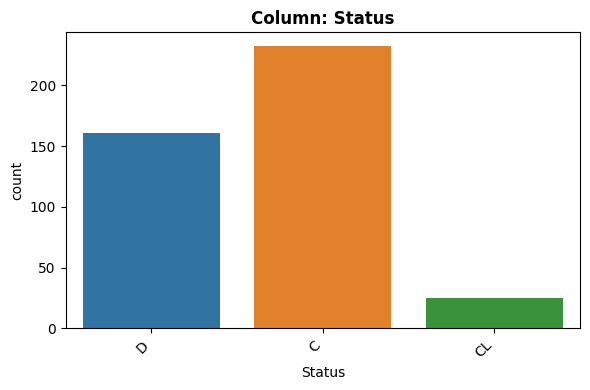

- Feature Type: Categorical
- NaN's Found: 0 (0.0%)
- Unique Values: 3
- Cardinality: Low
- Most common value: 'C' occurs 232 times (55.5%)
- Not constant or quasi-constant.


In [138]:
explore_categorical(df,'Status');

- Target feature is categorical with 3 categories. So, this is a classification problem.
- The data is unbalanced, we will deal with that later in the modeling phase.

## Numeric Features

In [180]:
num_cols = df.select_dtypes('number').columns
num_cols

Index(['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin'],
      dtype='object')

### N_Days


- The number of days between registration and the earlier of death, transplantation, or study analysis time in July 1986

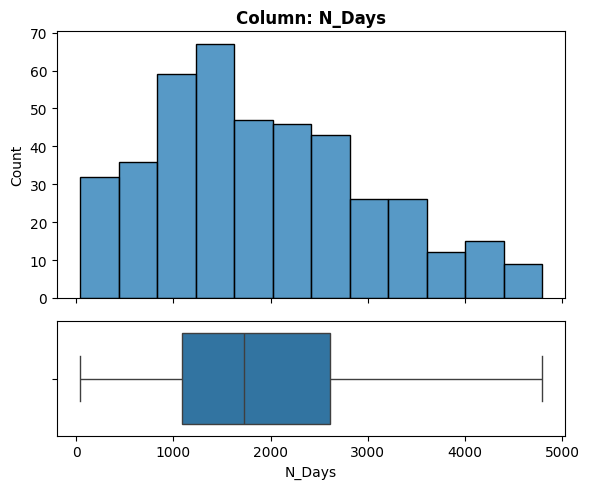

- NaN's Found: 0 (0.0%)
- Unique Values: 399
- Most common value: '1434' occurs 2 times (0.48%)
- Not constant or quasi-constant.


In [132]:
explore_numeric(df,'N_Days');

### Age


- Age of the patient in days.

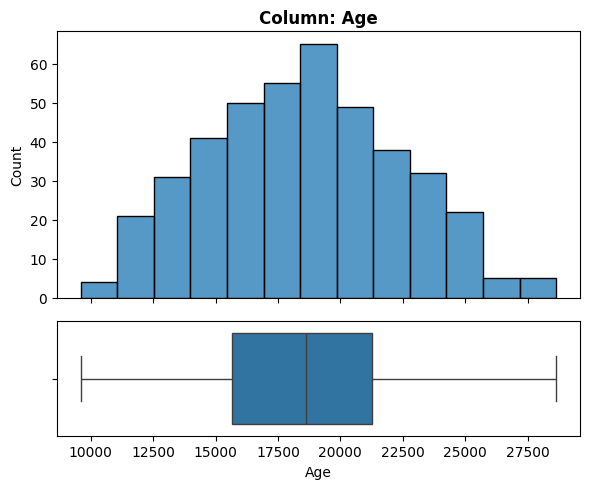

- NaN's Found: 0 (0.0%)
- Unique Values: 344
- Most common value: '19724' occurs 7 times (1.67%)
- Not constant or quasi-constant.


In [152]:
explore_numeric(df,'Age');

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Age vs. Status'}, xlabel='Status', ylabel='Age'>)

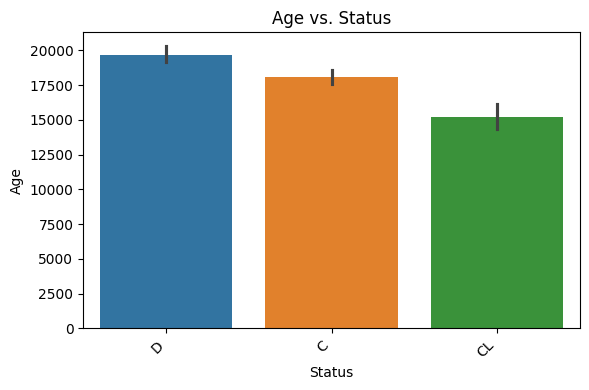

In [153]:
plot_numeric_vs_target(df,'Age')

- Looks like this feature is a predictor of the target because there is variability between the three classes.
- People who end up dying have higher average age.

### Bilirubin


- Serum bilirubin in ***mg/dl***

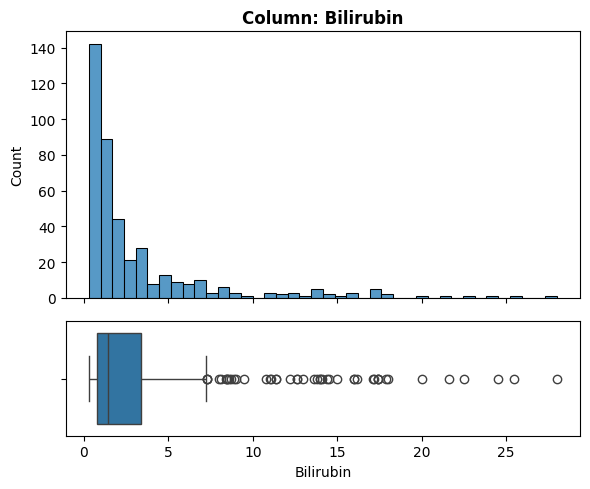

- NaN's Found: 0 (0.0%)
- Unique Values: 98
- Most common value: '0.7' occurs 33 times (7.89%)
- Not constant or quasi-constant.


In [157]:
explore_numeric(df,'Bilirubin');

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Bilirubin vs. Status'}, xlabel='Status', ylabel='Bilirubin'>)

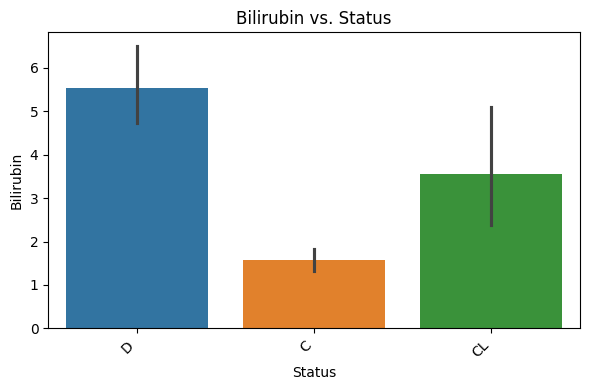

In [158]:
plot_numeric_vs_target(df,'Bilirubin')

- Typical levels: 0.1–1.2 mg/dL.
- The plot is right skewed and most of the people have lower levels less than 2.
- There are some extreme values, high bilirubin levels may indicate severe liver damage, often seen in cirrhosis.
- Variability with the target indicates that this feature might be a predictor of the target.
- Deceased patients have higher average bilirubin levels.

### Cholesterol


- Serum cholesterol in ***mg/dl***

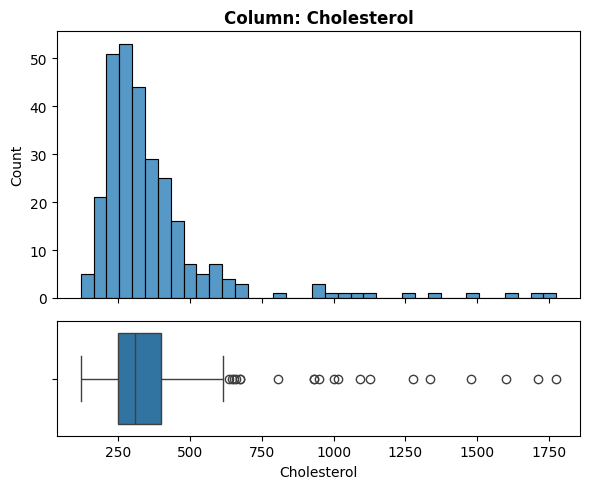

- NaN's Found: 134 (32.06%)
- Unique Values: 201
- Most common value: 'nan' occurs 134 times (32.06%)
- Not constant or quasi-constant.


In [159]:
explore_numeric(df,'Cholesterol');

- Excluding 134 NaN's


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Cholesterol vs. Status'}, xlabel='Status', ylabel='Cholesterol'>)

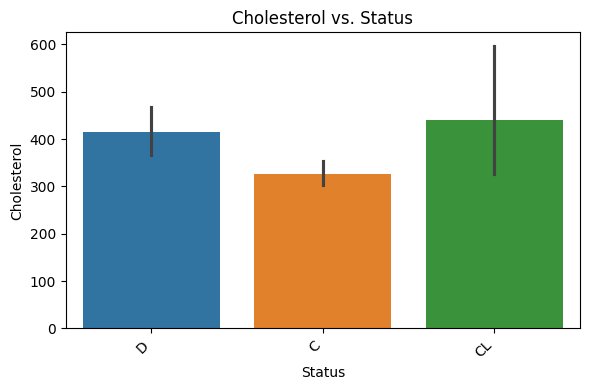

In [160]:
plot_numeric_vs_target(df,'Cholesterol')

- Typical levels:  150–200 mg/dL.
- The plot is right skewed and most of the people have lower levels less than 260.
- There are some extreme values.
- Variability with the target indicates that this feature might be a predictor of the target.
- Missing values will be imputed by the median strategy because of the skewness.

### Albumin


- Albumin in ***gm/dl***

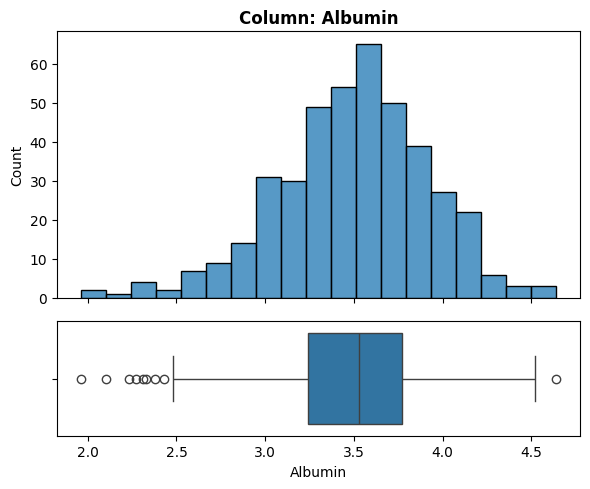

- NaN's Found: 0 (0.0%)
- Unique Values: 154
- Most common value: '3.35' occurs 11 times (2.63%)
- Not constant or quasi-constant.


In [161]:
explore_numeric(df,'Albumin');

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Albumin vs. Status'}, xlabel='Status', ylabel='Albumin'>)

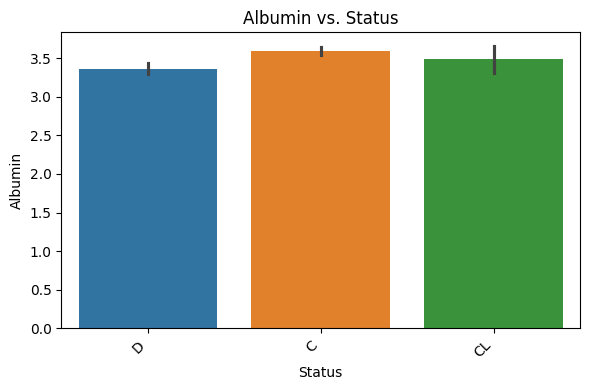

In [162]:
plot_numeric_vs_target(df,'Albumin')

- Reference range: 3.5–5.5 g/dL.
- Cirrhosis causes low albumin levels.

### Copper

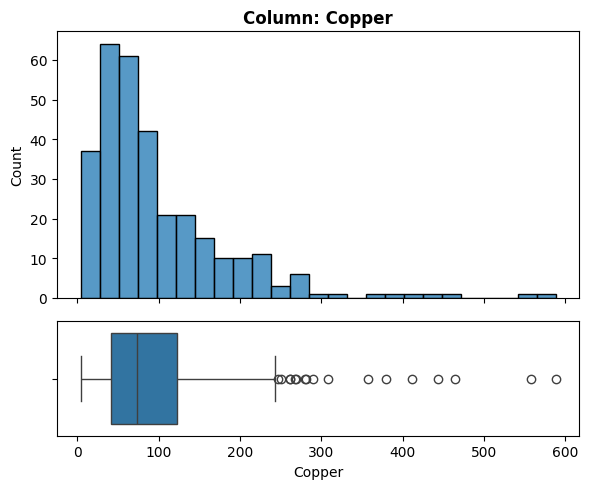

- NaN's Found: 108 (25.84%)
- Unique Values: 158
- Most common value: 'nan' occurs 108 times (25.84%)
- Not constant or quasi-constant.


In [163]:
explore_numeric(df,'Copper');

- Excluding 108 NaN's


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Copper vs. Status'}, xlabel='Status', ylabel='Copper'>)

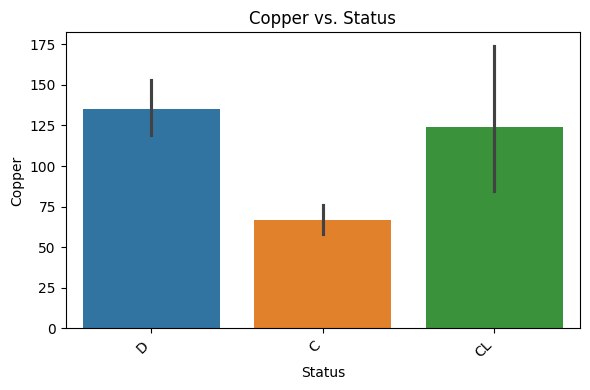

In [164]:
plot_numeric_vs_target(df,'Copper')

- Typical urine copper excretion: 20–50 μg/day.
- Right skewed and extreme values.
- Missing values will be imputed by the median strategy because of the skewness.
- Predictor.

### Alk_Phos

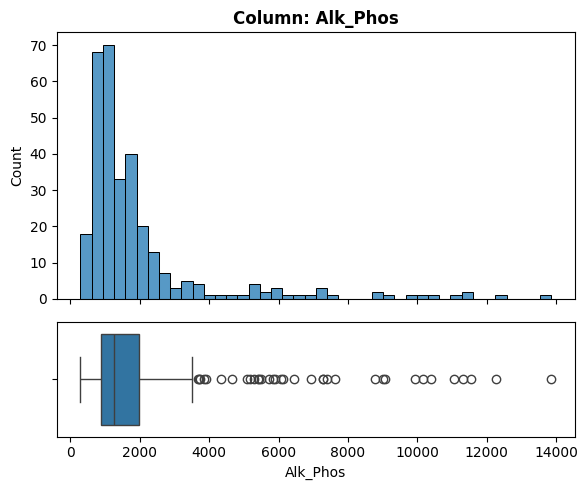

- NaN's Found: 106 (25.36%)
- Unique Values: 295
- Most common value: 'nan' occurs 106 times (25.36%)
- Not constant or quasi-constant.


In [165]:
explore_numeric(df,'Alk_Phos');

- Excluding 106 NaN's


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Alk_Phos vs. Status'}, xlabel='Status', ylabel='Alk_Phos'>)

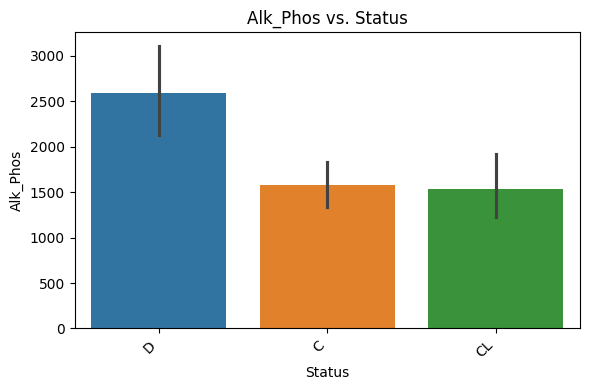

In [166]:
plot_numeric_vs_target(df,'Alk_Phos')

### SGOT

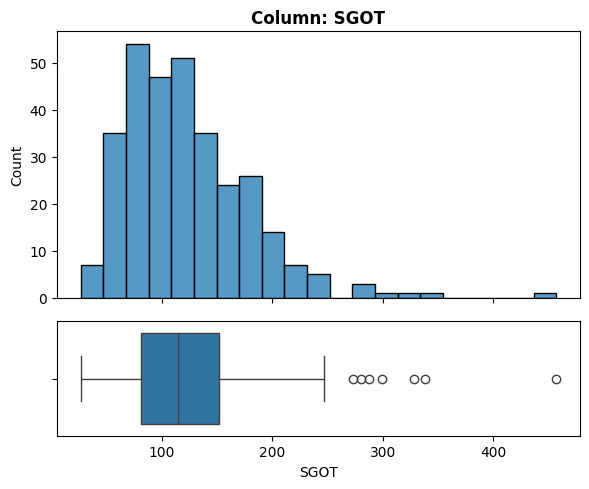

- NaN's Found: 106 (25.36%)
- Unique Values: 179
- Most common value: 'nan' occurs 106 times (25.36%)
- Not constant or quasi-constant.


In [167]:
explore_numeric(df,'SGOT');

- Excluding 106 NaN's


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'SGOT vs. Status'}, xlabel='Status', ylabel='SGOT'>)

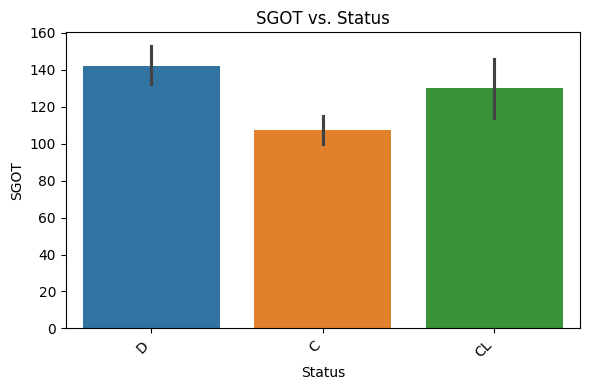

In [168]:
plot_numeric_vs_target(df,'SGOT')

### Tryglicerides

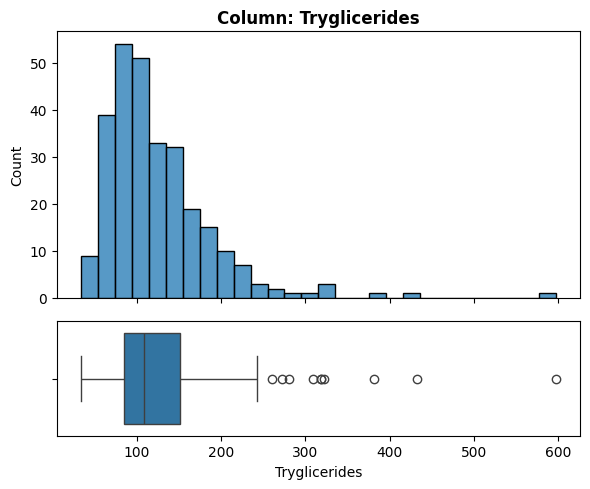

- NaN's Found: 136 (32.54%)
- Unique Values: 146
- Most common value: 'nan' occurs 136 times (32.54%)
- Not constant or quasi-constant.


In [170]:
explore_numeric(df,'Tryglicerides');

- Excluding 136 NaN's


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Tryglicerides vs. Status'}, xlabel='Status', ylabel='Tryglicerides'>)

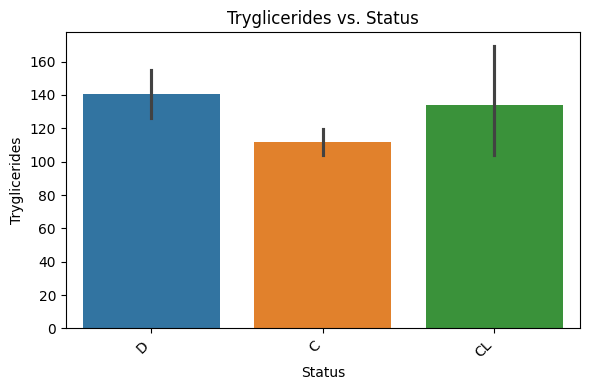

In [171]:
plot_numeric_vs_target(df,'Tryglicerides')

### Platelets

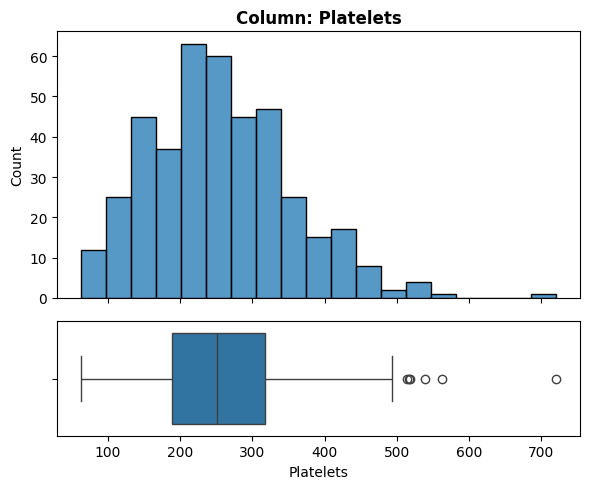

- NaN's Found: 11 (2.63%)
- Unique Values: 243
- Most common value: 'nan' occurs 11 times (2.63%)
- Not constant or quasi-constant.


In [172]:
explore_numeric(df,'Platelets');

- Excluding 11 NaN's


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Platelets vs. Status'}, xlabel='Status', ylabel='Platelets'>)

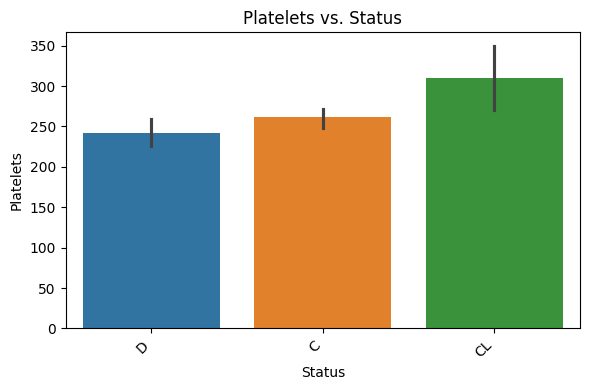

In [173]:
plot_numeric_vs_target(df,'Platelets')

### Prothrombin

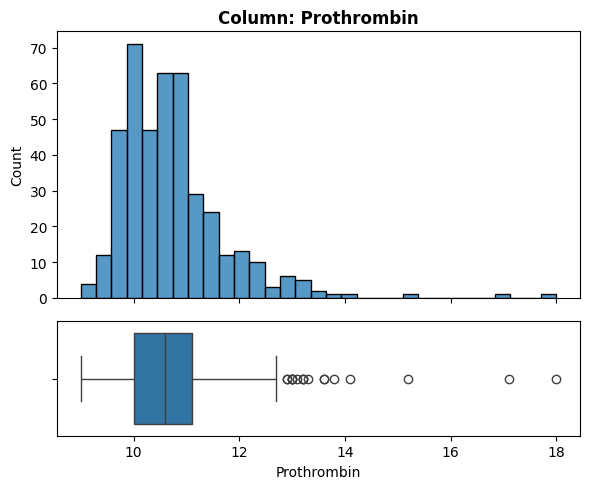

- NaN's Found: 2 (0.48%)
- Unique Values: 48
- Most common value: '10.6' occurs 39 times (9.33%)
- Not constant or quasi-constant.


In [174]:
explore_numeric(df,'Prothrombin');

- Excluding 2 NaN's


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Prothrombin vs. Status'}, xlabel='Status', ylabel='Prothrombin'>)

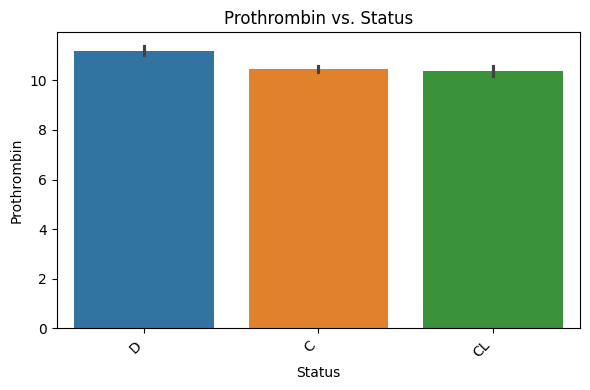

In [175]:
plot_numeric_vs_target(df,'Prothrombin')

## Categorical Features

In [181]:
cat_cols = df.select_dtypes('object').columns
cat_cols

Index(['Status', 'Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema',
       'Stage'],
      dtype='object')

### Drug


<ipython-input-150-1b803eef238c>:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, ha='right')
<ipython-input-150-1b803eef238c>:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, ha='right')


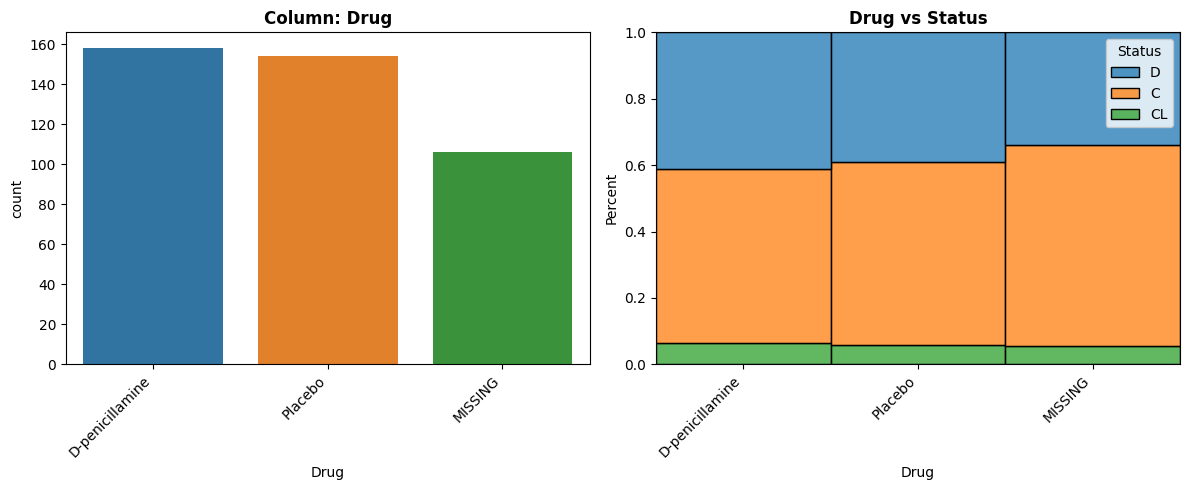

- Feature Type: Categorical
- NaN's Found: 106 (25.36%)
- Unique Values: 3
- Cardinality: Low
- Most common value: 'D-penicillamine' occurs 158 times (37.8%)
- Not constant or quasi-constant.


In [185]:
explore_catf_catt(df,'Drug', figsize=(12, 5));

### Sex


<ipython-input-150-1b803eef238c>:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, ha='right')
<ipython-input-150-1b803eef238c>:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, ha='right')


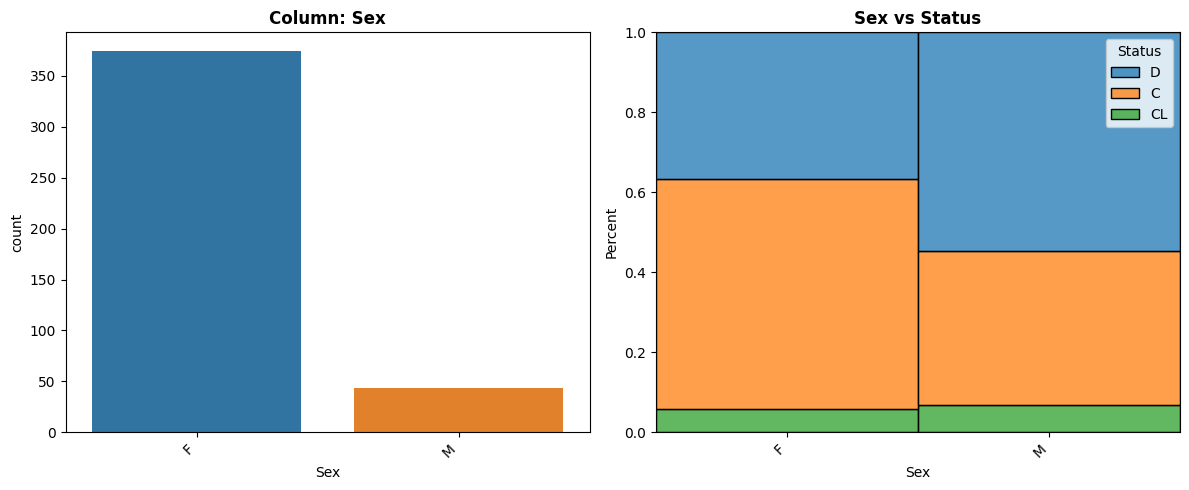

- Feature Type: Categorical
- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Cardinality: Low
- Most common value: 'F' occurs 374 times (89.47%)
- Not constant or quasi-constant.


In [187]:
explore_catf_catt(df,'Sex',  figsize=(12, 5));

### Ascites


<ipython-input-150-1b803eef238c>:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, ha='right')
<ipython-input-150-1b803eef238c>:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, ha='right')


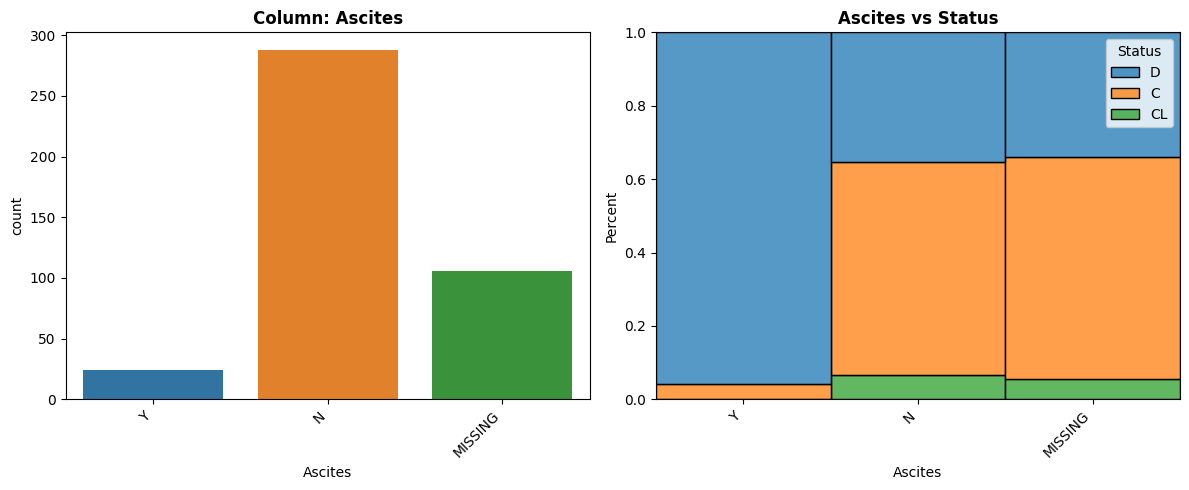

- Feature Type: Categorical
- NaN's Found: 106 (25.36%)
- Unique Values: 3
- Cardinality: Low
- Most common value: 'N' occurs 288 times (68.9%)
- Not constant or quasi-constant.


In [188]:
explore_catf_catt(df,'Ascites', figsize=(12, 5));

### Hepatomegaly


<ipython-input-150-1b803eef238c>:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, ha='right')
<ipython-input-150-1b803eef238c>:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, ha='right')


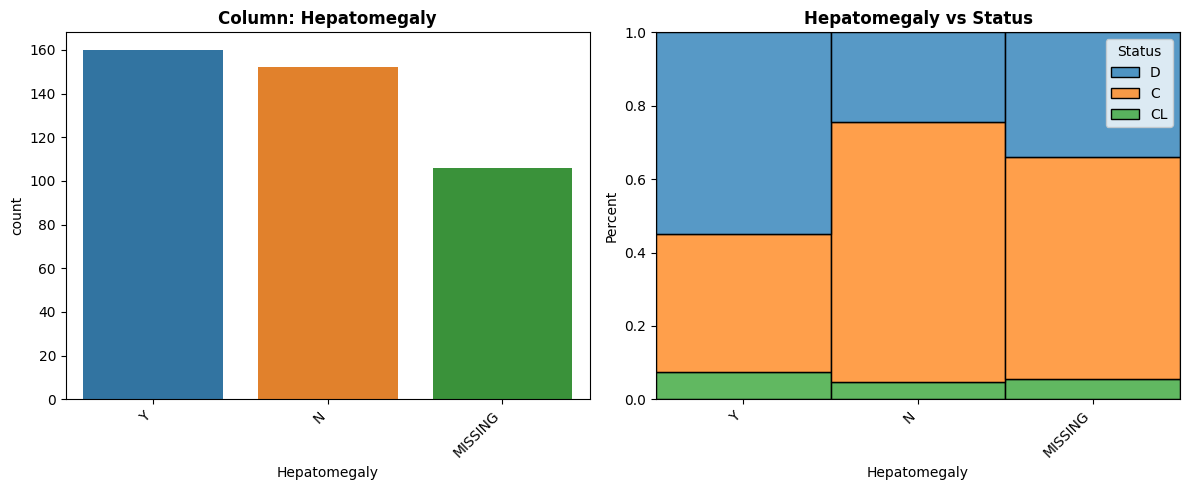

- Feature Type: Categorical
- NaN's Found: 106 (25.36%)
- Unique Values: 3
- Cardinality: Low
- Most common value: 'Y' occurs 160 times (38.28%)
- Not constant or quasi-constant.


In [189]:
explore_catf_catt(df,'Hepatomegaly', figsize=(12, 5));

### Spiders

<ipython-input-191-6ff17ec603a3>:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, ha='right')
<ipython-input-191-6ff17ec603a3>:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, ha='right')


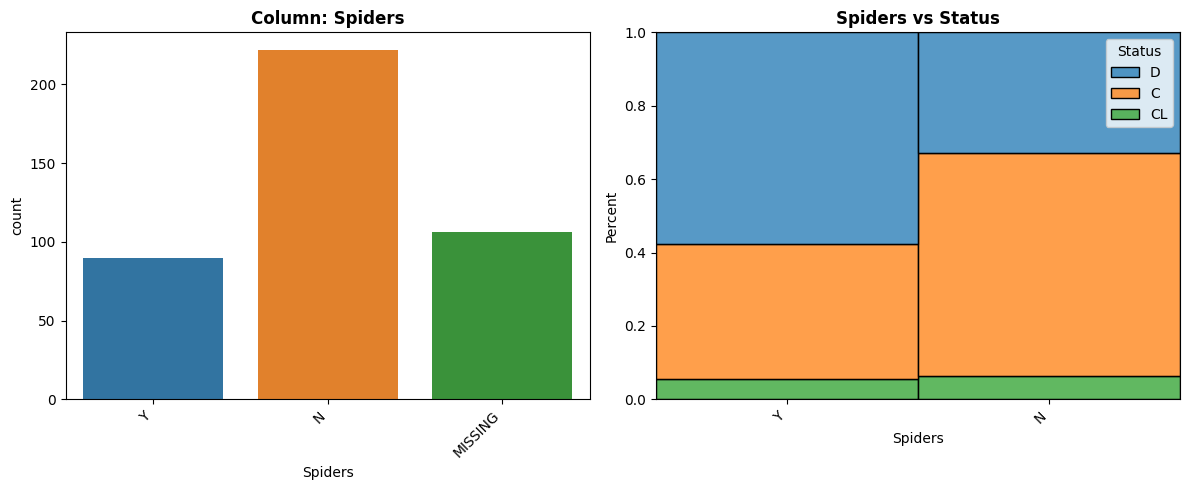

- Feature Type: Categorical
- NaN's Found: 106 (25.36%)
- Unique Values: 3
- Cardinality: Low
- Most common value: 'N' occurs 222 times (53.11%)
- Not constant or quasi-constant.


In [193]:
explore_catf_catt(df,'Spiders', figsize=(12, 5));

### Edema

<ipython-input-191-6ff17ec603a3>:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, ha='right')
<ipython-input-191-6ff17ec603a3>:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, ha='right')


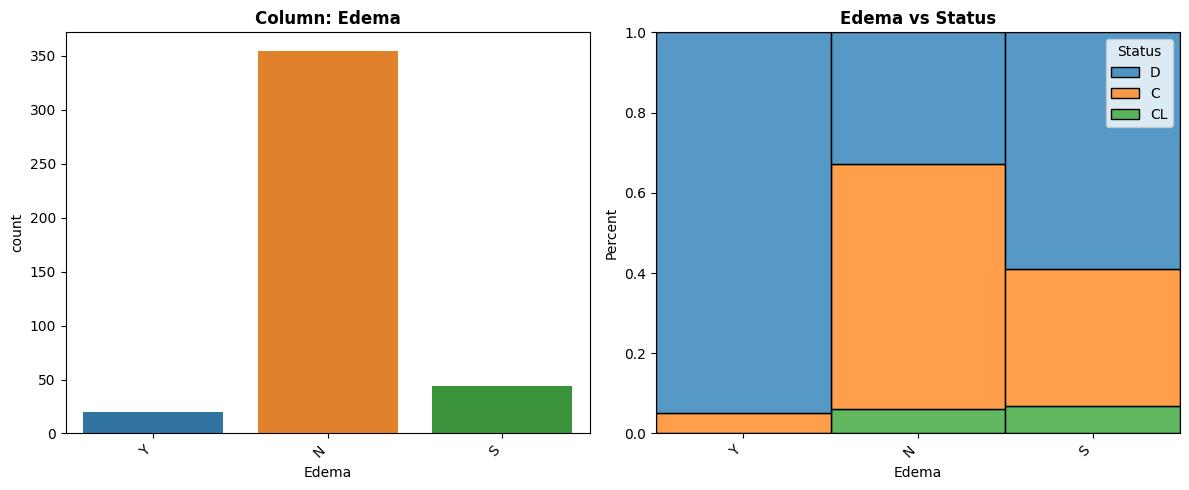

- Feature Type: Categorical
- NaN's Found: 0 (0.0%)
- Unique Values: 3
- Cardinality: Low
- Most common value: 'N' occurs 354 times (84.69%)
- Not constant or quasi-constant.


In [194]:
explore_catf_catt(df,'Edema', figsize=(12, 5));

### Stage

<ipython-input-191-6ff17ec603a3>:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, ha='right')
<ipython-input-191-6ff17ec603a3>:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, ha='right')


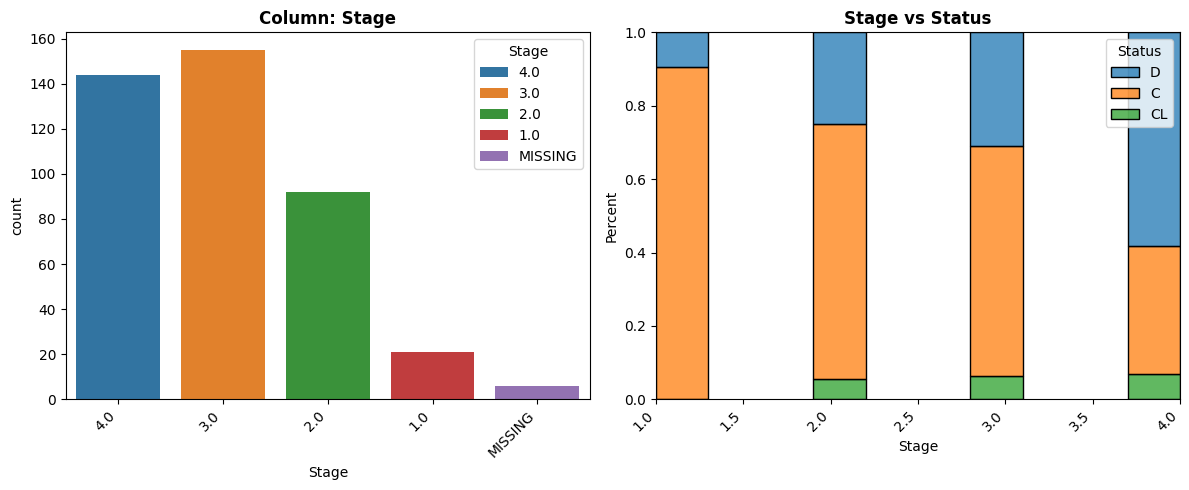

- Feature Type: Categorical
- NaN's Found: 6 (1.44%)
- Unique Values: 5
- Cardinality: Low
- Most common value: '3.0' occurs 155 times (37.08%)
- Not constant or quasi-constant.


In [192]:
explore_catf_catt(df,'Stage', figsize=(12, 5));

- There is variability across all of the features.
- Cateforical data missing values will be filled using the placeholder MISSING because on some of the features there are alot of missing values and filling with the most frequent may cause change in the data distribution.

In [201]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 1 to 418
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         418 non-null    int64  
 1   Status         418 non-null    object 
 2   Drug           312 non-null    object 
 3   Age            418 non-null    int64  
 4   Sex            418 non-null    object 
 5   Ascites        312 non-null    object 
 6   Hepatomegaly   312 non-null    object 
 7   Spiders        312 non-null    object 
 8   Edema          418 non-null    object 
 9   Bilirubin      418 non-null    float64
 10  Cholesterol    284 non-null    float64
 11  Albumin        418 non-null    float64
 12  Copper         310 non-null    float64
 13  Alk_Phos       312 non-null    float64
 14  SGOT           312 non-null    float64
 15  Tryglicerides  282 non-null    float64
 16  Platelets      407 non-null    float64
 17  Prothrombin    416 non-null    float64
 18  Stage          

In [202]:
df['Stage'] = df['Stage'].astype('float')

# Preprocessing

In [208]:
X = df.drop(columns=target)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [209]:
# Numerical data
num_cols = X.select_dtypes('number').columns
num_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)
num_tuple = ('Numeric', num_pipe, num_cols)

# Categorical Data
cat_cols = X.select_dtypes('object').columns
cat_pipe = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='MISSING'),
    OneHotEncoder(sparse_output=False, handle_unknown='ignore')
)
cat_tuple = ('Categorical', cat_pipe, cat_cols)

ct = ColumnTransformer([num_tuple, cat_tuple], verbose_feature_names_out=True)
ct

ColumnTransformer(transformers=[('Numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
       'Stage'],
      dtype='object')),
                                ('Categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema'], dtype='object'))])

In [210]:
ct.fit(X_train)
X_train_tf = ct.transform(X_train)
X_test_tf = ct.transform(X_test)

In [213]:
smote = SMOTE()
X_train_sm, y_train_sm = smote.fit_resample(X_train_tf , y_train)
y_train_sm.value_counts()

,count
Status,
C,174
D,174
CL,174


# Modeling

## Random Forest

In [217]:
rf_cls = RandomForestClassifier(random_state = 42)
rf_cls.fit(X_train_sm, y_train_sm)

RandomForestClassifier(random_state=42)

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           C       1.00      1.00      1.00       174
          CL       1.00      1.00      1.00       174
           D       1.00      1.00      1.00       174

    accuracy                           1.00       522
   macro avg       1.00      1.00      1.00       522
weighted avg       1.00      1.00      1.00       522



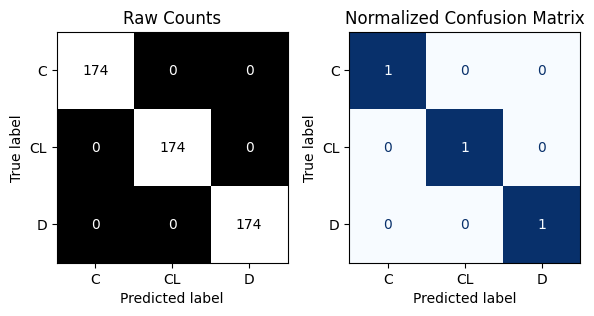


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           C       0.78      0.86      0.82        58
          CL       0.00      0.00      0.00         6
           D       0.76      0.71      0.73        41

    accuracy                           0.75       105
   macro avg       0.51      0.52      0.52       105
weighted avg       0.73      0.75      0.74       105



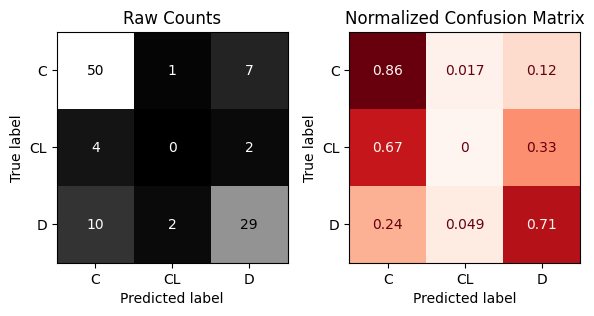

In [218]:
evaluate_classification(rf_cls, X_train_sm, y_train_sm, X_test_tf, y_test)

- The model is overfit.
- On the test data, it performs badly in predicting the CL class.

### Permutation Importance for Top 10 Features

In [222]:
r = permutation_importance(rf_cls, X_train_tf, y_train ,n_repeats =5, random_state = 42)
perm_importances = pd.Series(r['importances_mean'],index=X_train_sm.columns,
                           name = 'permutation importance')
importances = perm_importances.sort_values(ascending=False)
importances.head()

,permutation importance
Numeric__Age,0.060064
Numeric__Prothrombin,0.040256
Numeric__Bilirubin,0.040256
Numeric__N_Days,0.026837
Numeric__SGOT,0.007029


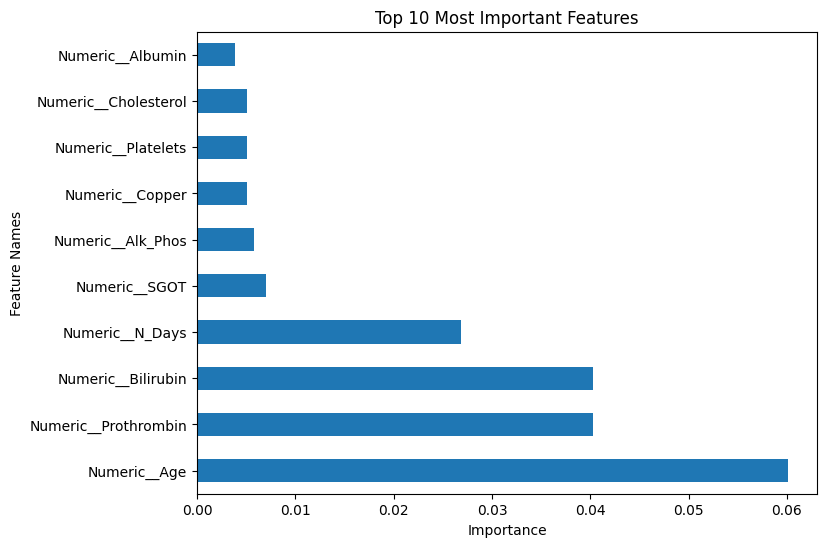

In [225]:
ax = importances.head(10).plot(kind='barh', figsize=(8,6))
ax.set(xlabel='Importance',
        ylabel='Feature Names',
        title='Top 10 Most Important Features');

## PCA

In [250]:
pca = PCA()
df_pca = pca.fit_transform(X_train_sm)
df_pca.head()

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,...,pca20,pca21,pca22,pca23,pca24,pca25,pca26,pca27,pca28,pca29
0,-0.803108,-0.933005,-1.642157,1.580516,1.098991,-1.239213,-1.912879,0.985610,-0.257851,0.026395,...,0.088706,-4.440892e-16,8.881784e-16,-1.387779e-17,5.467848e-15,4.510281e-16,-5.551115e-16,1.387779e-15,4.718448e-16,-1.554312e-15
1,-2.598392,-0.257729,-0.528784,0.480385,0.484294,-0.576593,0.327717,-1.288593,-0.653382,0.123132,...,0.063290,4.440892e-16,-1.110223e-16,-3.469447e-16,2.692291e-15,-1.040834e-16,-1.665335e-16,-2.775558e-16,-8.326673e-17,3.330669e-16
2,0.295120,-1.351491,0.010029,0.061302,-0.295802,-0.423705,-0.237048,-0.113363,0.052248,1.362764,...,-0.034269,-2.220446e-16,5.551115e-16,-6.938894e-17,-2.303713e-15,2.289835e-16,1.665335e-16,9.436896e-16,1.942890e-16,-7.771561e-16
3,-1.128236,-0.520281,-1.195468,-0.414562,1.378941,1.509176,0.316932,-0.552737,0.532180,-0.355529,...,-0.060724,1.110223e-15,2.220446e-16,-1.249001e-16,1.387779e-16,-1.040834e-16,6.661338e-16,-6.106227e-16,1.387779e-16,1.110223e-16
4,-0.624845,1.814413,-0.123192,1.271255,1.706244,-0.613778,1.189852,-0.205639,-1.987111,-0.053959,...,-0.766724,1.332268e-15,-1.443290e-15,1.151856e-15,-5.981327e-14,6.175616e-16,1.776357e-15,1.165734e-15,1.526557e-15,1.221245e-15


In [252]:
explained = pd.Series(pca.explained_variance_ratio_, name='Explained Variance Ratio')
explained.head()

,Explained Variance Ratio
0,0.197414
1,0.132926
2,0.091837
3,0.076030
4,0.072632


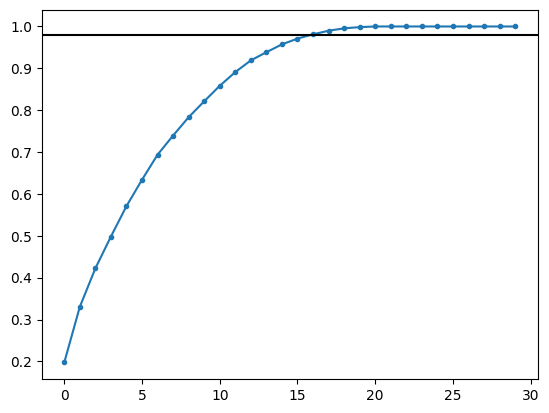

In [255]:
ax = explained.cumsum().plot(marker='.')
ax.axhline(.98, color='k');

- 98% of the variance can be explained only using 17 features.

In [260]:
pca17 = PCA(n_components=.98)
# fit and transform on training data
X_train_pca17 = pca17.fit_transform(X_train_sm)
# transform test data
X_test_pca17 = pca17.transform(X_test_tf)
# obtain the number of PCs used
pca17.n_components_

17

## Kmeans clustering

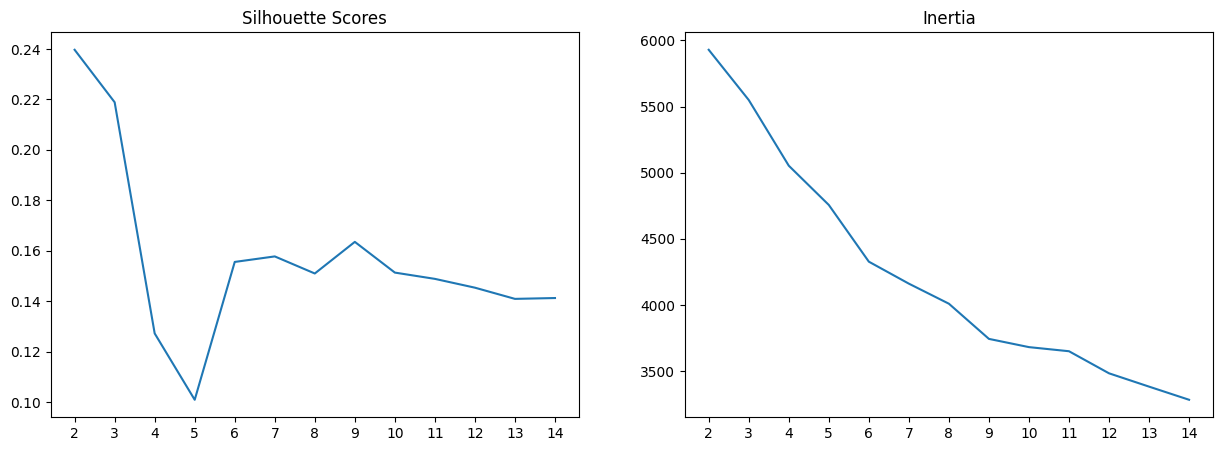

In [240]:
k = 15
range_k = range(2, k)
inertias = []
silhouette_scores = []
for k in range(2,k):
    kmeans = KMeans(n_clusters=k, n_init = 'auto', random_state = 42)
    kmeans.fit(X_train_sm)
    silhouette_scores.append(silhouette_score(X_train_sm, kmeans.labels_))
    inertias.append(kmeans.inertia_)

#plot inertias and silhouette scores for each number of clusters.
fig, axes = plt.subplots(1,2, figsize=(15,5))
axes[0].plot(range_k, silhouette_scores)
axes[0].set_title('Silhouette Scores')
axes[0].set_xticks(range_k)
axes[1].plot(range_k, inertias)
axes[1].set_title('Inertia')
axes[1].set_xticks(range_k);

In [242]:
# 2 clusters because it ie where the highest silhouette score is
kmeans = KMeans(n_clusters=2, n_init = 'auto', random_state = 42)
kmeans.fit(X_train_sm)

X_train_sm['cluster'] = kmeans.labels_
X_train_sm.head()

,Numeric__N_Days,Numeric__Age,Numeric__Bilirubin,Numeric__Cholesterol,Numeric__Albumin,Numeric__Copper,Numeric__Alk_Phos,Numeric__SGOT,Numeric__Tryglicerides,Numeric__Platelets,...,Categorical__Hepatomegaly_MISSING,Categorical__Hepatomegaly_N,Categorical__Hepatomegaly_Y,Categorical__Spiders_MISSING,Categorical__Spiders_N,Categorical__Spiders_Y,Categorical__Edema_N,Categorical__Edema_S,Categorical__Edema_Y,cluster
0,1.168505,1.263777,-0.526099,0.291252,0.853380,-0.781015,-0.427107,-1.266246,2.449620,-0.096412,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1
1,0.577366,-0.006492,-0.640835,-1.130044,-0.012183,-0.979560,-0.400499,-1.418751,-0.685038,0.791147,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1
2,-0.315651,-0.930204,-0.250733,0.155428,-0.175938,-0.508017,-0.233318,1.234838,1.644775,0.729224,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1
3,1.309081,0.230143,0.001686,-0.489733,1.859305,1.427791,-0.411544,-0.229211,-0.812119,0.109997,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1
4,1.034237,0.985168,-0.434310,-0.281147,-1.766702,-0.433563,-0.169057,-1.540756,-0.091995,0.739545,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1


In [247]:
X_test_tf['cluster'] = kmeans.predict(X_test_tf)
X_test_tf.head()

,Numeric__N_Days,Numeric__Age,Numeric__Bilirubin,Numeric__Cholesterol,Numeric__Albumin,Numeric__Copper,Numeric__Alk_Phos,Numeric__SGOT,Numeric__Tryglicerides,Numeric__Platelets,...,Categorical__Hepatomegaly_MISSING,Categorical__Hepatomegaly_N,Categorical__Hepatomegaly_Y,Categorical__Spiders_MISSING,Categorical__Spiders_N,Categorical__Spiders_Y,Categorical__Edema_N,Categorical__Edema_S,Categorical__Edema_Y,cluster
ID,,,,,,,,,,,,,,,,,,,,,
329,-0.432797,1.205012,-0.571993,-0.213235,-0.246119,-0.247427,-0.290049,-0.107207,-0.208486,1.173004,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1
229,-1.436653,1.148870,0.300000,-0.819590,-1.064894,1.328519,-0.421585,1.051832,0.035086,-1.221342,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0
215,-0.777028,-0.886917,0.621260,4.443570,0.806593,0.596386,-0.329209,1.600850,0.861111,-0.426667,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0
104,1.030633,-0.709835,-0.480205,-0.276296,0.315328,-0.905106,0.124640,0.136801,-1.341622,0.945954,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1
179,0.568355,-0.621163,-0.319574,0.174832,0.759806,-0.669334,0.144721,-0.381716,0.352788,0.213202,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1


## Random Forest with 17 component

In [261]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_pca17, y_train_sm)

RandomForestClassifier(random_state=42)

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           C       1.00      1.00      1.00       174
          CL       1.00      1.00      1.00       174
           D       1.00      1.00      1.00       174

    accuracy                           1.00       522
   macro avg       1.00      1.00      1.00       522
weighted avg       1.00      1.00      1.00       522



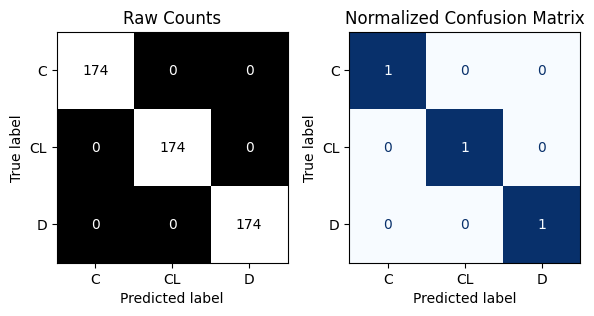


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           C       0.72      0.71      0.71        58
          CL       0.20      0.17      0.18         6
           D       0.65      0.68      0.67        41

    accuracy                           0.67       105
   macro avg       0.52      0.52      0.52       105
weighted avg       0.66      0.67      0.66       105



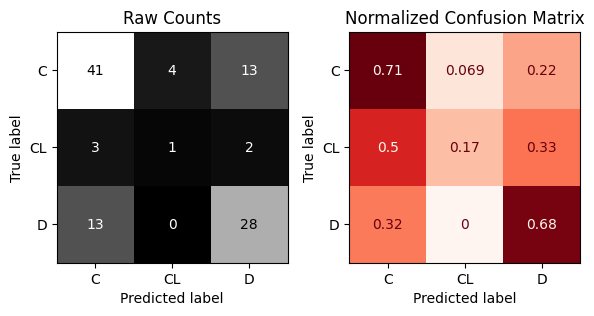

In [262]:
evaluate_classification(clf, X_train_pca10,y_train_sm, X_test_pca10, y_test)

- Still overfit but performs overall better on the test set.

## Filter Method - Variance

In [265]:
selector = VarianceThreshold(threshold=0.09)
selector.fit(X_train_sm)

VarianceThreshold(threshold=0.09)

In [266]:
keep_features = selector.get_support()
keep_features[:20]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False,  True,
        True, False])

In [267]:
keep_features.sum()

25

In [270]:
X_train_var = X_train_sm.loc[:,keep_features]
X_test_var = X_test_tf.loc[:,keep_features]
X_train_var.head()

,Numeric__N_Days,Numeric__Age,Numeric__Bilirubin,Numeric__Cholesterol,Numeric__Albumin,Numeric__Copper,Numeric__Alk_Phos,Numeric__SGOT,Numeric__Tryglicerides,Numeric__Platelets,...,Categorical__Ascites_MISSING,Categorical__Ascites_N,Categorical__Hepatomegaly_MISSING,Categorical__Hepatomegaly_N,Categorical__Hepatomegaly_Y,Categorical__Spiders_MISSING,Categorical__Spiders_N,Categorical__Spiders_Y,Categorical__Edema_N,cluster
0,1.168505,1.263777,-0.526099,0.291252,0.853380,-0.781015,-0.427107,-1.266246,2.449620,-0.096412,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1
1,0.577366,-0.006492,-0.640835,-1.130044,-0.012183,-0.979560,-0.400499,-1.418751,-0.685038,0.791147,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1
2,-0.315651,-0.930204,-0.250733,0.155428,-0.175938,-0.508017,-0.233318,1.234838,1.644775,0.729224,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1
3,1.309081,0.230143,0.001686,-0.489733,1.859305,1.427791,-0.411544,-0.229211,-0.812119,0.109997,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1
4,1.034237,0.985168,-0.434310,-0.281147,-1.766702,-0.433563,-0.169057,-1.540756,-0.091995,0.739545,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1


----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           C       1.00      1.00      1.00       174
          CL       1.00      1.00      1.00       174
           D       1.00      1.00      1.00       174

    accuracy                           1.00       522
   macro avg       1.00      1.00      1.00       522
weighted avg       1.00      1.00      1.00       522



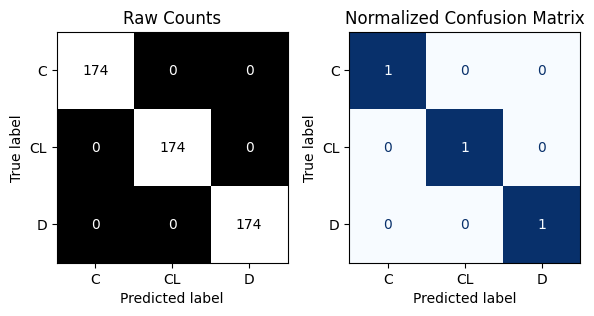


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           C       0.76      0.86      0.81        58
          CL       0.00      0.00      0.00         6
           D       0.75      0.66      0.70        41

    accuracy                           0.73       105
   macro avg       0.50      0.51      0.50       105
weighted avg       0.71      0.73      0.72       105



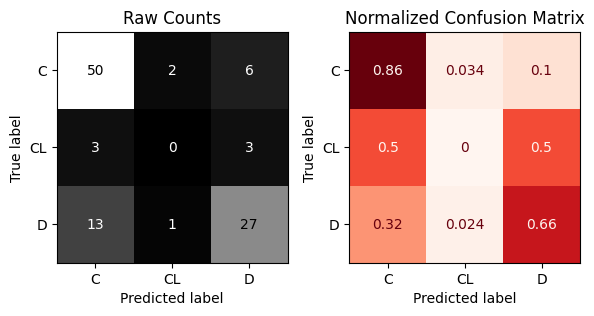

In [271]:
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train_var, y_train_sm)
evaluate_classification(rf_clf, X_train_var, y_train_sm, X_test_var, y_test)

## Neural Networks